In [1]:
import pandas as pd
import lightgbm as lgb
import catboost as cb
import numpy as np
import re
import optuna
import json
from itertools import product
from data_preprocessing import *
import yaml
import matplotlib.pyplot as plt

# Data Preprocessing

- 数値列は数値型に変換、カテゴリ列はカテゴリ型に変換
- 不要な列やカテゴリ数が多すぎる列は削除して意味のない情報を除去
- 将来情報となる列（`RES_COLS`、`PAYOUT_COLS`）は後で使用するため定義
- モデルでは使用しないが前処理で便利なオッズ列（`ODDS_COLS`）を定義
- 日付やレース情報、斤量などの列を分割・整形してデータを扱いやすくする

これにより、モデルが各特徴量を適切に扱いやすい形式に整えています。

In [2]:
data = pd.read_csv("data.csv", encoding="cp932")
RACE_COL = "レースID(新/馬番無)"
HORSE_COL = "馬名S"
RES_COLS = ["着順", "単勝配当", "複勝配当", "馬連", "馬単", "３連複", "３連単", '走破タイム', "着差タイム", '上3F地点差',
            '1角', '2角', '3角', '4角', '決め手', '脚質', 'Ave-3F', '上り3F', '上り3F順', 'PCI', 'PCI3', 'RPCI',
            '平均1Fタイム', '補正', '補9', '基準タイム',]
ODDS_COLS = ['人気', '単勝オッズ', '複勝オッズ下限', '複勝オッズ上限']
DROP_COLS = ["多頭出し", 'レース名', '前レース名', '性別限定', '指定条件', '重量種別', '限定', "生後日数",
             "市場取引価格(万/最終)", 'ｺｰﾅｰ', "年齢限定", "複勝人気", "複勝シェア", "前重量", "前複勝シェア", '好走',
             '母馬', '馬主(最新/仮想)', '生産者', "前好走", "前複勝人気", "芝(内・外)", '前人気', '前単勝オッズ',
             '前複勝オッズ下限', '前複勝オッズ上限']
PAYOUT_COLS = ["単勝配当", "複勝配当", "馬連", "馬単", "３連複", "３連単"]
CAT_COLS = ["場所", "性別", "騎手", "芝・ダ", "コース区分", "天気", "所属", "調教師", "ブリンカー", "馬記号",
            "トラックコード(JV)", "前トラックコード(JV)", "産地", "種牡馬", "父タイプ名", "母父馬", "母父タイプ名",
            "前場所", "替", "前騎手", "前場所", "前芝・ダ",  "前決め手", "前脚質", "前ブリンカー"]

In [3]:
df = data.copy()
df = rename_race_columns(df)
df.drop(DROP_COLS, axis=1, inplace=True)
df = split_datetimes(df, ["日付S", "前日付S"])
df = split_race_meeting(df, ["開催", "前開催"])
df = condition_to_numeric(df, ["馬場状態", "前馬場状態"])
df = race_class_to_numeric(df, ["クラス名", "前クラス名"])
df = split_kinryo(df, ["斤量", "前斤量"])
df = clean_finish_position(df, "着順")
df = clean_finish_position(df, "前着順", drop=False)
df = time_columns_to_seconds(df, ["走破タイム", "基準タイム", "前走破タイム", "前基準タイム"])
df = clean_time_columns(df, ["着差タイム", "前着差タイム"])
df = clean_tansho_column(df, "単勝配当")
df[RACE_COL] = df[RACE_COL].astype(str)
df = convert_int_columns_to_float(df)
df[PAYOUT_COLS] = df[PAYOUT_COLS].fillna(0)
df = exclude_shogai_races(df)
df = make_categorical(df, CAT_COLS)
df = add_last_5_races(df)
CAT_COLS = df.select_dtypes(include="category").columns.tolist()
df = prepare_catboost_categoricals(df, CAT_COLS)
df = df.sort_values([RACE_COL, "馬番"]).reset_index(drop=True)
df = df[df["芝・ダ"]=="芝"] # Focus only on 芝 since model did not perform well with ダ
df.head()

Dropped 2234 rows out of 271134 (0.82%) where 着順 is 消, 外, or 止


,場所,Ｒ,クラス名,馬名S,性別,年齢,騎手,騎手年齢,斤量,馬齢斤量差,...,last1_前開催日数,last2_前開催日数,last3_前開催日数,last4_前開催日数,last5_前開催日数,last1_前斤量減量,last2_前斤量減量,last3_前斤量減量,last4_前斤量減量,last5_前斤量減量
64,中山,5.0,1.0,ルトロヴァイユ,牝,3.0,吉田豊,44.0,54.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,中山,5.0,1.0,コスモスタック,牡,3.0,野中悠太,23.0,55.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,中山,5.0,1.0,ヒシエレガンス,牡,3.0,Ｍ．デム,40.0,56.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,中山,5.0,1.0,シークレットローザ,牝,3.0,三浦皇成,30.0,54.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,中山,5.0,1.0,アンサンブル,牝,3.0,フォーリ,31.0,54.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training

LightGBMおよびCatBoostモデルで学習するために、以下の処理を行います。

- **ラベル生成**  
  学習モードに応じてラベルを定義（`rank`, `binary`, `regression`）。  
  - `rank`: 着順を逆転させて学習用の順位ラベルを作成  
  - `binary`: 3着以内かどうかで0/1ラベル  
  - `regression`: 勝馬なら単勝配当、それ以外は複勝配当や0でラベル化

- **学習用/検証用データ分割**  
  日付に基づき訓練データと検証データを分割。  

- **重み付け**  （現在は未使用）
  必要に応じて勝ち馬や複勝配当に基づいたサンプル重みを計算し、損失関数に反映可能。  

- **ハイパーパラメータ読み込み**  
  YAMLファイルからモデルごとのパラメータを読み込み

In [4]:
def generate_sample_weights(df, train_mask, valid_mask, win_importance=1.0, 
                            place_importance=1.0, bias=0.5):
    weights_train = win_importance * (df.loc[train_mask, "単勝配当"].values / 100)
    weights_valid = win_importance * (df.loc[valid_mask, "単勝配当"].values / 100)

    mask_train_zero = weights_train == 0
    mask_valid_zero = weights_valid == 0
    weights_train[mask_train_zero] = (
        place_importance * (df.loc[train_mask, "複勝配当"].values[mask_train_zero] / 100)
    )
    weights_valid[mask_valid_zero] = (
        place_importance * (df.loc[valid_mask, "複勝配当"].values[mask_valid_zero] / 100)
    )

    weights_train[weights_train == 0] = bias
    weights_valid[weights_valid == 0] = bias

    weights_train = np.minimum(weights_train, 20)
    weights_valid = np.minimum(weights_valid, 20)

    return weights_train, weights_valid


def generate_data_lightgbm(X_train, y_train, X_valid, y_valid, weights_train, weights_valid, params):
    group_train = X_train.groupby(RACE_COL).size().to_list()
    group_valid = X_valid.groupby(RACE_COL).size().to_list()
    train_data = lgb.Dataset(
        X_train.drop(columns=[RACE_COL, HORSE_COL] + ODDS_COLS), label=y_train["label"], weight=weights_train, group=group_train, params=params
    )
    valid_data = lgb.Dataset(
        X_valid.drop(columns=[RACE_COL, HORSE_COL] + ODDS_COLS), label=y_valid["label"], weight=weights_valid, group=group_valid, params=params
    )
    return train_data, valid_data

def generate_data_catboost(X_train, y_train, X_valid, y_valid, weights_train, weights_valid):
    train_data = cb.Pool(
        data=X_train.drop(columns=[RACE_COL, HORSE_COL] + ODDS_COLS),
        label=y_train["label"],
        group_id=X_train[RACE_COL],
        weight=weights_train,
        cat_features=CAT_COLS
    )
    valid_data = cb.Pool(
        data=X_valid.drop(columns=[RACE_COL, HORSE_COL] + ODDS_COLS),
        label=y_valid["label"],
        group_id=X_valid[RACE_COL],
        weight=weights_valid,
        cat_features=CAT_COLS
    )
    return train_data, valid_data

def generate_train_valid(df, params, mode, model_type):
    """Generates train and valid dataset based on given mode and model_type"""
    y = df[[RACE_COL, HORSE_COL] + RES_COLS].copy()
    if mode == "rank":
        y["label"] = df.groupby(RACE_COL)["着順"].transform(lambda x: x.max() - x)
    elif mode == "binary":
        y["label"] = (df["着順"] <= 3).astype(int)
    elif mode == "regression":
        y["label"] = df["単勝配当"].where(df["着順"] == 1, 0)
        mask_23 = (df["着順"] > 1) & (df["着順"] <= 3)
        y.loc[mask_23, "label"] = df.loc[mask_23, "複勝配当"]
    else:
        raise ValueError(f"Unknown mode: {mode}")

    X = df.drop(RES_COLS, axis=1).copy()
    train_mask = X["日付S年"] < 2025
    valid_mask = X["日付S年"] == 2025
    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask]
    weights_train, weights_valid = np.ones(len(y_train)), np.ones(len(y_valid))
    # TODO: Consider using weights
    # weights_train, weights_valid = generate_sample_weights(df, train_mask, valid_mask)

    if model_type=="lightgbm":
        train_data, valid_data = generate_data_lightgbm(X_train, y_train, X_valid, y_valid,
                                                        weights_train, weights_valid, params)
    elif model_type=="catboost":
        train_data, valid_data = generate_data_catboost(X_train, y_train, X_valid, y_valid,
                                                         weights_train, weights_valid)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    return train_data, valid_data, X_valid, y_valid

In [5]:
def load_params(mode, model_type):
    with open(f"params_{model_type}.yaml", "r") as f:
        raw_params = yaml.safe_load(f)
    
    params_bin = {**raw_params["common_params"], **raw_params["params_bin"]}
    params_rank = {**raw_params["common_params"], **raw_params["params_rank"]}
    params_reg = {**raw_params["common_params"], **raw_params["params_reg"]}
    params = {"rank": params_rank, "binary": params_bin, "regression": params_reg}[mode]
    return params

def train_model(df, params, mode, model_type):
    train_data, valid_data, X_valid, y_valid = generate_train_valid(df, params, mode, model_type)
    if model_type=="lightgbm":
        model = lgb.train(params, train_set=train_data, valid_sets=[valid_data])
    elif model_type=="catboost":
        model = cb.CatBoost(params).fit(train_data, eval_set=valid_data)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    return model, X_valid, y_valid

# Hyperparameter tuning

- **勝率予測 (`predict_win_probs`)**  
  学習済みモデルを使って各馬のスコアを予測し、レースごとにソフトマックスで正規化して勝つ確率を算出します。

- **予測結果と実績の統合 (`merge_predictions_with_results`)**  
  予測勝率と実際の結果を結合して、後続の評価や可視化に使用できる形式に整形

- **目的関数 (`objective`)**  
  Optuna でのハイパーパラメータ探索用の目的関数  
  - LightGBM と CatBoost に対応し、それぞれのハイパーパラメータ空間を定義  
  - 学習後、検証データで勝率を予測し、実際の単勝配当との積を計算して **総配当（total payout）** として評価  
  - Optuna はこの総配当を最大化する方向でパラメータ探索を行う


In [6]:
def predict_win_probs(model, X):
    X_out = X.copy()
    # Predict raw scores
    if "lightgbm" in str(type(model)).lower():
        X_out["score"] = model.predict(
            X_out.drop(columns=[RACE_COL, HORSE_COL] + ODDS_COLS),
            num_iteration=getattr(model, "best_iteration", None)
        )
    elif "catboost" in str(type(model)).lower():
        X_out["score"] = model.predict(
            X_out.drop(columns=[RACE_COL, HORSE_COL] + ODDS_COLS)
        )
    else:
        raise TypeError(f"Unsupported model type: {type(model)}")

    def softmax(x):
        e_x = np.exp(x - np.max(x))  # numerical stability
        return e_x / e_x.sum()

    X_out["win_prob"] = X_out.groupby(RACE_COL)["score"].transform(
        lambda s: softmax(s.values)
    )

    return X_out

def merge_predictions_with_results(predicted, result):
    merged = predicted.merge(result, on=[RACE_COL, HORSE_COL], how="left")
    return merged

In [7]:
def objective(trial, mode, model_type):
    if mode!="rank":
        raise ValueError(f"Unsupported mode '{mode}' for this objective. Only 'rank' is allowed.")

    if model_type=="lightgbm": 
        trial_params = {
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 127),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
            "lambdarank_truncation_level": trial.suggest_int("lambdarank_truncation_level", 1, 30),
            "verbosity": -1,
        }
    elif model_type=="catboost":
        trial_params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "depth": trial.suggest_int("depth", 3, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "verbose": False
        }

    params = load_params(mode, model_type)
    params.update(trial_params)
    model, X_valid, y_valid = train_model(df, params, mode, model_type)
    pred = predict_win_probs(model, X_valid)
    merged_results = merge_predictions_with_results(pred, y_valid)
    total_payout = (merged_results["win_prob"] * merged_results["単勝配当"]).sum()

    return total_payout

# Example usage
mode = "rank"  # "rank", "binary", or "regression"
model_type = "lightgbm"

study_name = f"{model_type}_{mode}"  # Unique identifier of the study.
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction="maximize",
    load_if_exists=True
)
# Uncomment to optimize hyperparams
#study.optimize(lambda t: objective(t, mode, model_type), n_trials=200) 

best_trial = study.best_trial
best_params = {**best_trial.params}
params = load_params(mode, model_type)
params.update(best_params)
model, X_valid, y_valid = train_model(df, params, mode, model_type)

[I 2025-09-16 15:51:55,245] Using an existing study with name 'lightgbm_rank' instead of creating a new one.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21718
[LightGBM] [Info] Number of data points in the train set: 110870, number of used features: 285
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's ndcg@1: 0.392669	valid_0's ndcg@2: 0.449882	valid_0's ndcg@3: 0.494174	valid_0's ndcg@4: 0.535901	valid_0's ndcg@5: 0.573637


# Evaluate model

- **目的**  
  予測勝率と実際の単勝オッズの関係を 2 次元ヒストグラム・等高線で可視化し、どの範囲の勝率・オッズで高配当が出やすいかを確認する

- **処理の流れ**
  1. 勝率とオッズの範囲を `bins` で分割して 2D グリッドを作成
  2. 各グリッド内で、単勝配当の合計を計算 (`payout_hist`)
  3. 各グリッド内の馬の数をカウント (`count_hist`)
  4. 平均配当を計算 (`mean_payout = payout_hist / count_hist`)
  5. 等高線図 (`contourf`) で可視化  
     - X 軸: 単勝オッズ  
     - Y 軸: 予測勝率  
     - 色: 平均配当  
  6. 各グリッド内に「平均配当（対象馬数）」を文字で表示

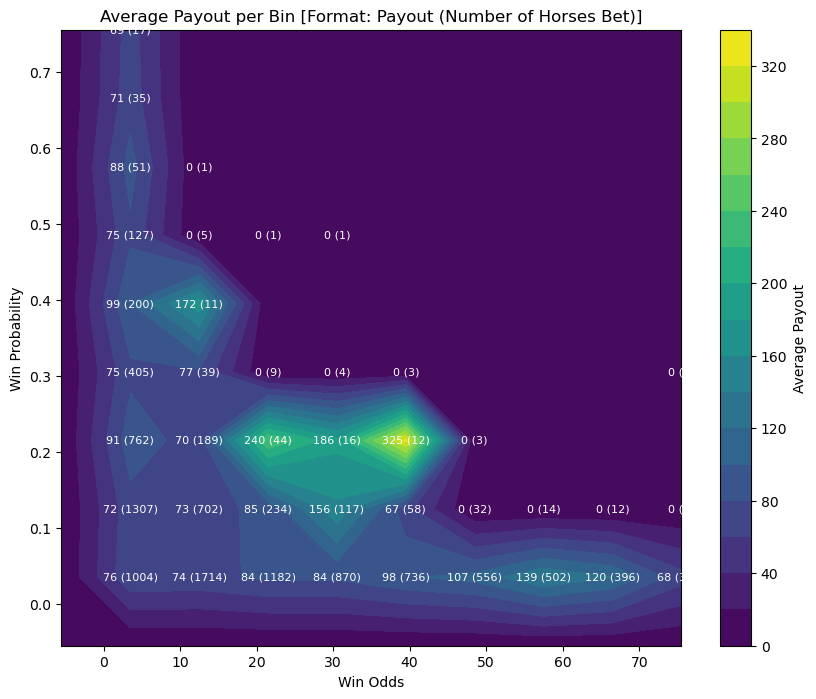

In [8]:
def plot_payout_contours(df, bins=20):
    # Define edges
    prob_edges = np.linspace(-0.1, 0.8, bins + 1)
    odds_edges = np.linspace(-10.0, 80.0, bins + 1)
    X, Y = np.meshgrid(
        (odds_edges[:-1] + odds_edges[1:]) / 2,
        (prob_edges[:-1] + prob_edges[1:]) / 2
    )

    # 2D histogram weighted by payout
    payout_hist, _, _ = np.histogram2d(
        df["単勝オッズ"],
        df["win_prob"],
        bins=[odds_edges, prob_edges],
        weights=df["単勝配当"]
    )
    count_hist, _, _ = np.histogram2d(
        df["単勝オッズ"],
        df["win_prob"],
        bins=[odds_edges, prob_edges]
    )

    # Compute mean payout per bin
    mean_payout = payout_hist / np.maximum(count_hist, 1)

    # Plot contour
    plt.figure(figsize=(10, 8))
    cont = plt.contourf(X, Y, mean_payout.T, levels=20, cmap='viridis')
    plt.colorbar(cont, label='Average Payout')
    plt.xlabel('Win Odds')
    plt.ylabel('Win Probability')
    plt.title("Average Payout per Bin [Format: Payout (Number of Horses Bet)]")

    # Add numbers inside bins
    for i in range(mean_payout.shape[0]):
        for j in range(mean_payout.shape[1]):
            if count_hist[i, j] > 0:
                plt.text(
                    X[j, i], Y[j, i],
                    f'{mean_payout[i, j]:.0f} ({int(count_hist[i, j])})',
                    color='white', ha='center', va='center', fontsize=8, clip_on=False
                )
    plt.show()


pred = predict_win_probs(model, X_valid)
merged_results = merge_predictions_with_results(pred, y_valid)
plot_payout_contours(merged_results, bins=10)

In [11]:
pred = predict_win_probs(model, X_valid)
total_num_races = len(pred[RACE_COL].unique())
pred = pred[(pred["単勝オッズ"] > 20) & (pred["win_prob"] > 0.15)]
merged_result = merge_predictions_with_results(pred, y_valid)
print("Number of Races:", total_num_races)
print("Number of Races Bet:", len(merged_result[RACE_COL].unique()))
print("Average payout:", merged_result["単勝配当"].mean())

Number of Races: 1153
Number of Races Bet: 92
Average payout: 144.79166666666666


In [12]:
def get_feature_importance(model, model_type="lightgbm"):
    if model_type == "catboost":
        # CatBoost
        importance = model.get_feature_importance(type='PredictionValuesChange')
        feature_names = model.feature_names_
    elif model_type == "lightgbm":
        # LightGBM
        importance = model.feature_importance(importance_type='gain')
        feature_names = model.feature_name()
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    feat_imp['order'] = range(1, len(feat_imp) + 1)
    return feat_imp

feat_imp = get_feature_importance(model, model_type)
feat_imp.iloc[:10]

,feature,importance,order
19,調教師,47713.413083,1
62,母父馬,37871.261927,2
5,騎手,27952.616243,3
60,種牡馬,13404.244130,4
31,前騎手,12520.562292,5
35,前着順,11498.190371,6
64,前補正,9309.006588,7
96,last1_前騎手,8476.189308,8
97,last2_前騎手,6656.416535,9
98,last3_前騎手,3675.438825,10
